In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

# Directory where graphs are saved
save_dir = "../../build/graphs/"

# Get a list of all GraphML files
graph_files = glob(os.path.join(save_dir, "*_graph.graphml"))

# Initialize a dictionary to hold graphs per subject
graphs = {}
subjects = []

for file_path in graph_files:
    # Extract subject name from filename
    subject = os.path.basename(file_path).replace("_graph.graphml", "")
    subjects.append(subject)
    
    # Load the graph
    G = nx.read_graphml(file_path)
    
    # Ensure node identifiers are strings
    G = nx.convert_node_labels_to_integers(G, label_attribute='professor_id') if not all(isinstance(n, str) for n in G.nodes()) else G
    
    graphs[subject] = G

print(f"Loaded graphs for subjects: {subjects}")

Loaded graphs for subjects: ['Energy', 'Veterinary', 'Dentistry', 'Business, Management and Accounting', 'Social Sciences', 'Chemistry', 'Medicine', 'Computer Science', 'Agricultural and Biological Sciences', 'Decision Sciences', 'Pharmacology, Toxicology and Pharmaceutics', 'Economics, Econometrics and Finance', 'Physics and Astronomy', 'Biochemistry, Genetics and Molecular Biology', 'Chemical Engineering', 'Nursing', 'Materials Science', 'Mathematics', 'Environmental Science', 'Neuroscience', 'Earth and Planetary Sciences', 'Immunology and Microbiology', 'Psychology', 'Arts and Humanities']


In [4]:
def compute_centrality_measures(G):
    centrality = {}
    centrality['degree_centrality'] = nx.degree_centrality(G)
    centrality['betweenness_centrality'] = nx.betweenness_centrality(G, weight='weight', normalized=True)
    centrality['closeness_centrality'] = nx.closeness_centrality(G)
    try:
        centrality['eigenvector_centrality'] = nx.eigenvector_centrality_numpy(G, weight='weight')
    except nx.PowerIterationFailedConvergence:
        # Handle convergence issues by assigning zero
        centrality['eigenvector_centrality'] = {node: 0 for node in G.nodes()}
    return centrality

# Initialize a list to collect centrality data
centrality_data = []

for subject, G in graphs.items():
    centrality = compute_centrality_measures(G)
    
    for node in G.nodes():
        centrality_data.append({
            'subject': subject,
            'professor_id': node,
            'degree_centrality': centrality['degree_centrality'].get(node, 0),
            'betweenness_centrality': centrality['betweenness_centrality'].get(node, 0),
            'closeness_centrality': centrality['closeness_centrality'].get(node, 0),
            'eigenvector_centrality': centrality['eigenvector_centrality'].get(node, 0)
        })

# Convert to DataFrame
centrality_df = pd.DataFrame(centrality_data)

In [5]:
centrality_df

,subject,professor_id,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality
0,Energy,1,0.000000,0.0,0.000000,-1.431923e-18
1,Energy,3,0.000000,0.0,0.000000,-3.799787e-21
2,Energy,6,0.001287,0.0,0.001287,-3.461674e-18
3,Energy,139,0.001287,0.0,0.001287,-4.435419e-18
4,Energy,221,0.001287,0.0,0.001287,-1.623979e-17
...,...,...,...,...,...,...
46137,Arts and Humanities,48276,0.000000,0.0,0.000000,-4.336809e-19
46138,Arts and Humanities,48402,0.000000,0.0,0.000000,-0.000000e+00
46139,Arts and Humanities,48410,0.000000,0.0,0.000000,-0.000000e+00
46140,Arts and Humanities,48578,0.000000,0.0,0.000000,-2.775558e-17


In [6]:
centrality_df.to_csv("../../build/centrality_measures.csv", index=False)

In [ ]:
top_n = 5  # Number of top nodes to identify

def get_top_nodes(df, measure, n=5):
    return df.groupby('subject').apply(
        lambda x: x.nlargest(n, measure)
    ).reset_index(drop=True)

top_degree = get_top_nodes(centrality_df, 'degree_centrality', top_n)
top_betweenness = get_top_nodes(centrality_df, 'betweenness_centrality', top_n)
top_closeness = get_top_nodes(centrality_df, 'closeness_centrality', top_n)
top_eigenvector = get_top_nodes(centrality_df, 'eigenvector_centrality', top_n)


In [8]:
top_degree

,subject,professor_id,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality
0,Agricultural and Biological Sciences,64,0.008043,0.019328,0.113134,0.000735
1,Agricultural and Biological Sciences,41,0.005362,0.009487,0.111407,0.001712
2,Agricultural and Biological Sciences,18840,0.004826,0.016153,0.107545,0.000021
3,Agricultural and Biological Sciences,29308,0.004826,0.007132,0.112187,0.000809
4,Agricultural and Biological Sciences,15235,0.004647,0.015334,0.111495,0.000278
...,...,...,...,...,...,...
115,Veterinary,387,0.040472,0.110078,0.129153,0.651307
116,Veterinary,33535,0.021922,0.011687,0.098879,0.004281
117,Veterinary,20917,0.021922,0.022310,0.095391,0.000139
118,Veterinary,835,0.020236,0.038446,0.105214,0.006234


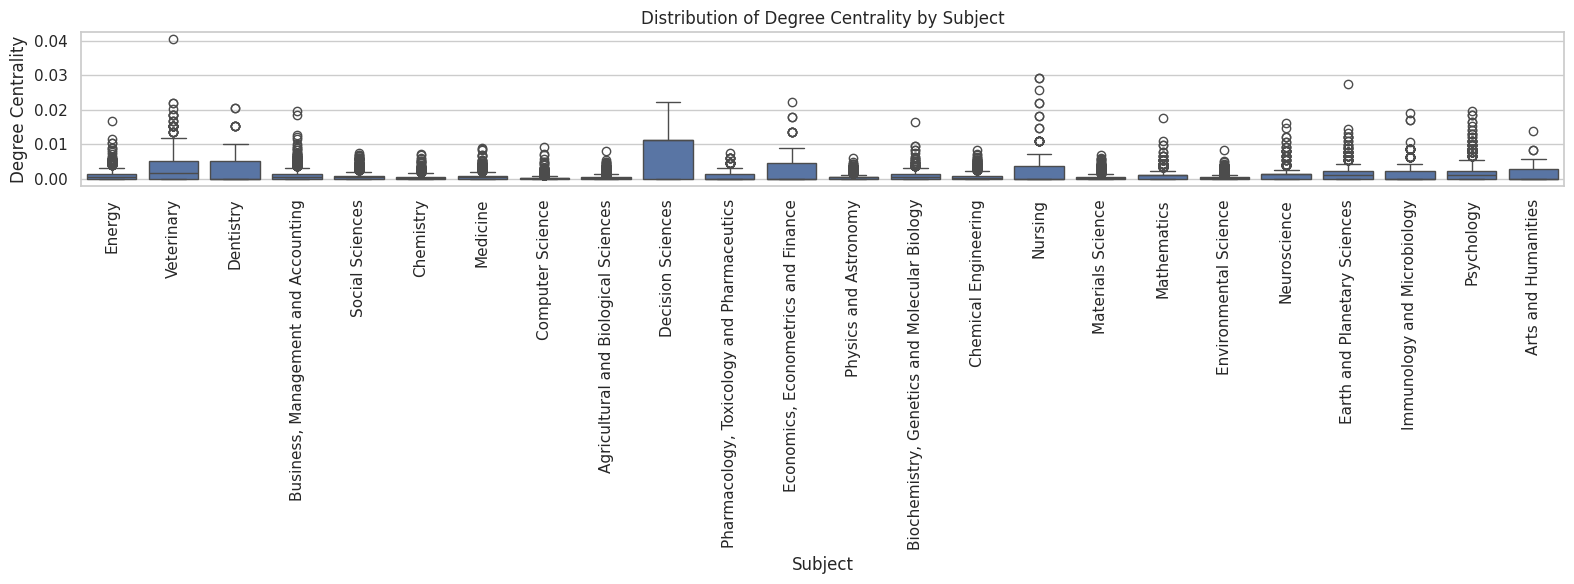

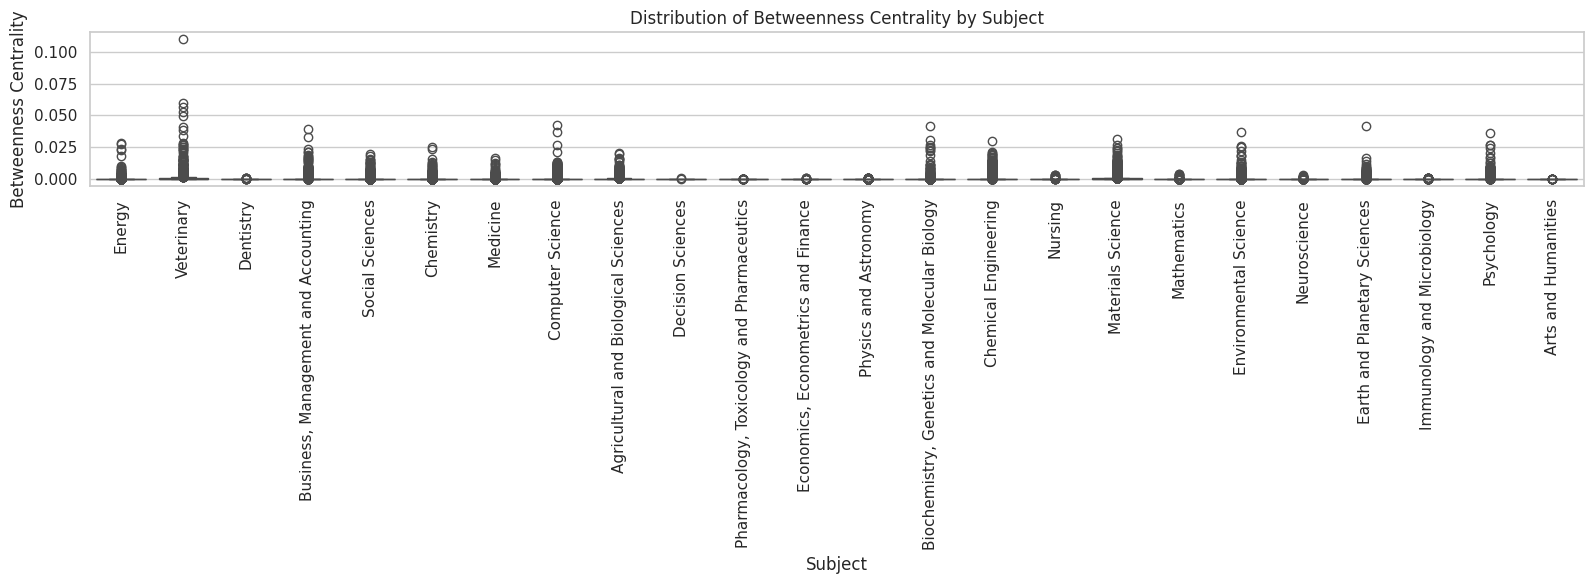

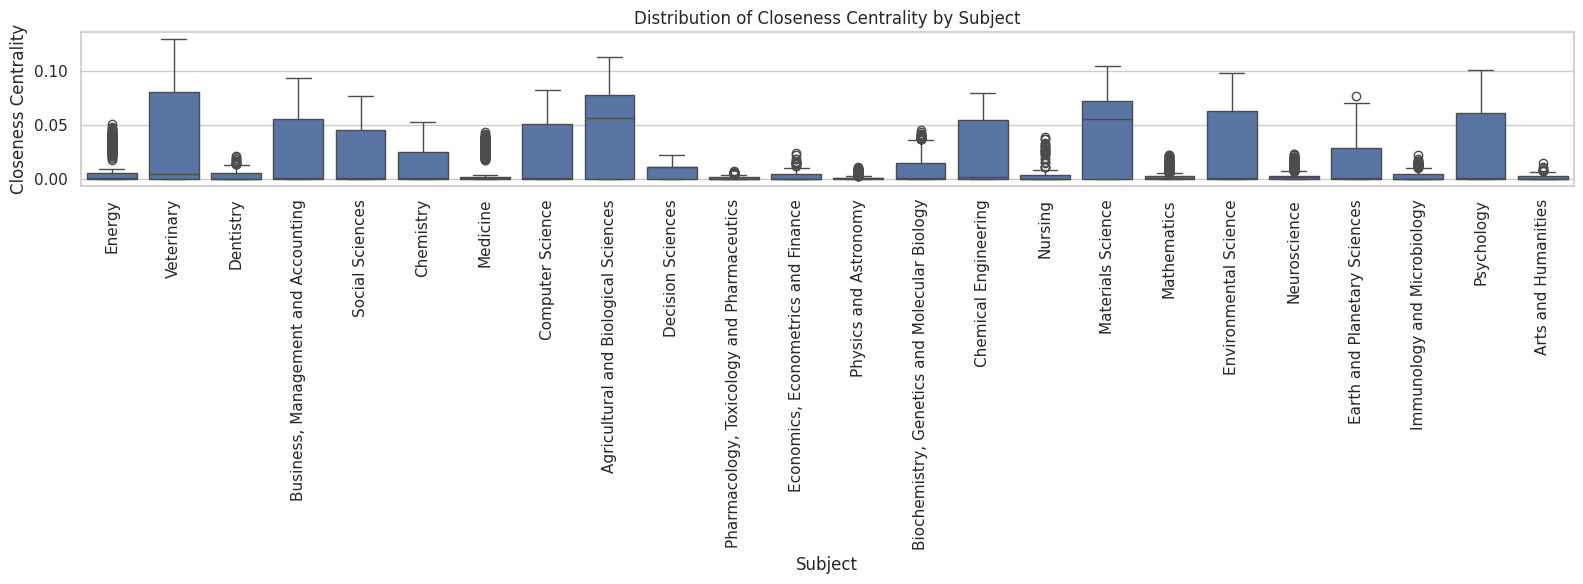

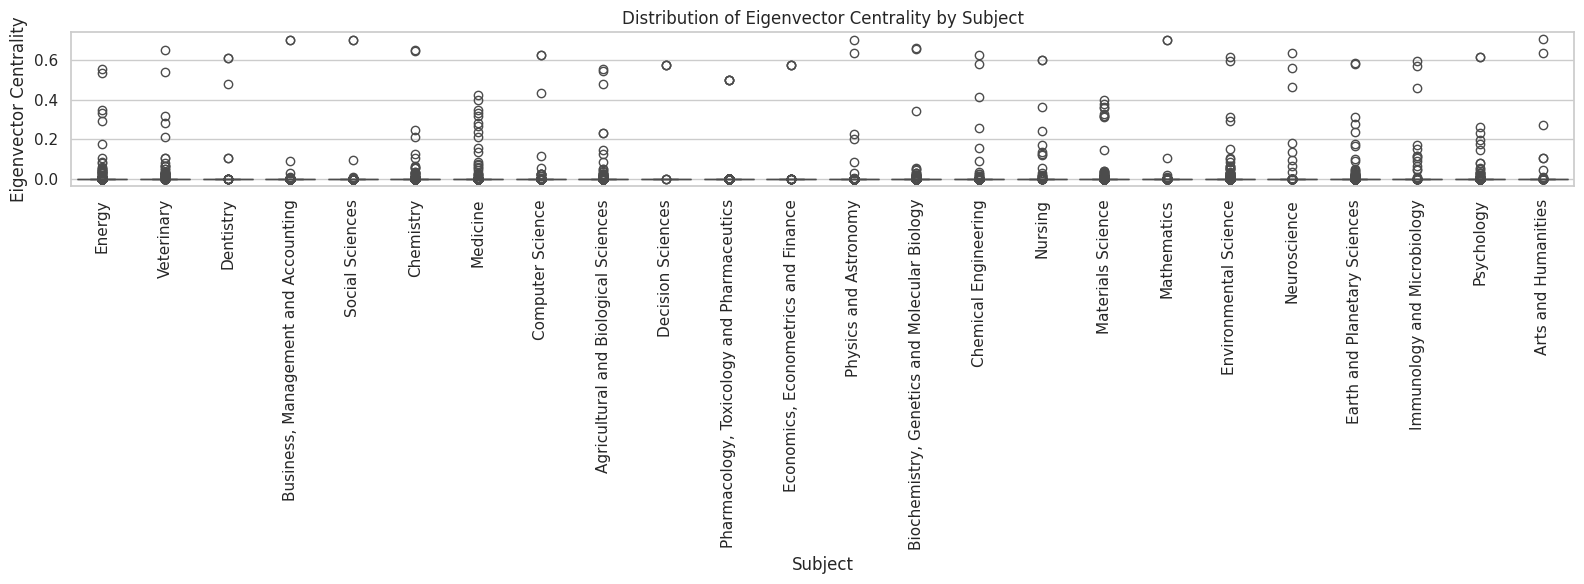

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# List of centrality measures to plot
centrality_measures = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']

for measure in centrality_measures:
    plt.figure(figsize=(16, 6))
    sns.boxplot(x='subject', y=measure, data=centrality_df)
    plt.title(f'Distribution of {measure.replace("_", " ").title()} by Subject')
    plt.xlabel('Subject')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


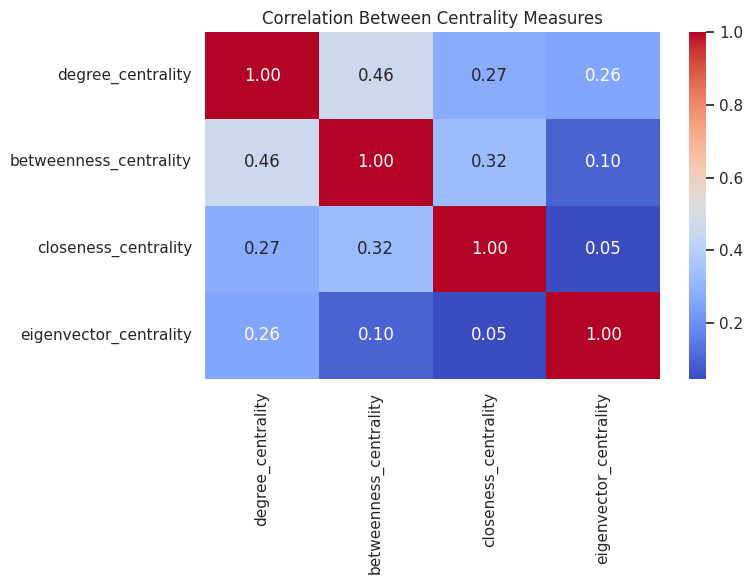

In [10]:
# Calculate correlation matrix
corr_matrix = centrality_df[centrality_measures].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Centrality Measures')
plt.tight_layout()
plt.show()


/tmp/ipykernel_26943/1904838849.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='subject', y='degree_centrality', data=centrality_df, ci=None, estimator='mean', palette='viridis')
/tmp/ipykernel_26943/1904838849.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='subject', y='degree_centrality', data=centrality_df, ci=None, estimator='mean', palette='viridis')


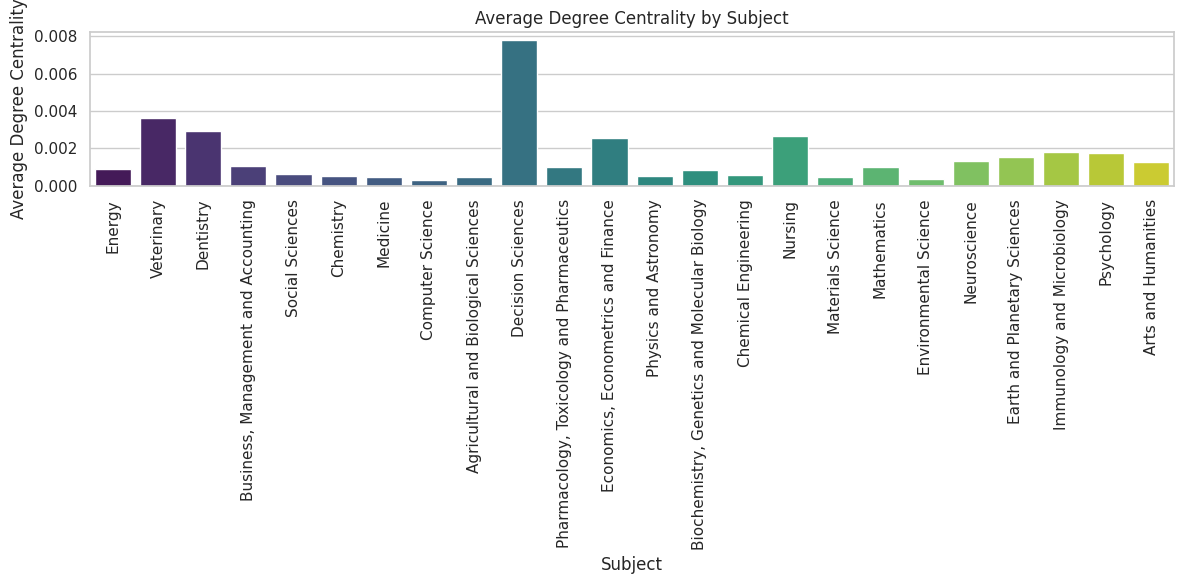

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x='subject', y='degree_centrality', data=centrality_df, ci=None, estimator='mean', palette='viridis')
plt.title('Average Degree Centrality by Subject')
plt.xlabel('Subject')
plt.ylabel('Average Degree Centrality')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/tmp/ipykernel_26943/2827244024.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='subject', y='betweenness_centrality', data=centrality_df, ci=None, estimator='mean', palette='magma')
/tmp/ipykernel_26943/2827244024.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='subject', y='betweenness_centrality', data=centrality_df, ci=None, estimator='mean', palette='magma')


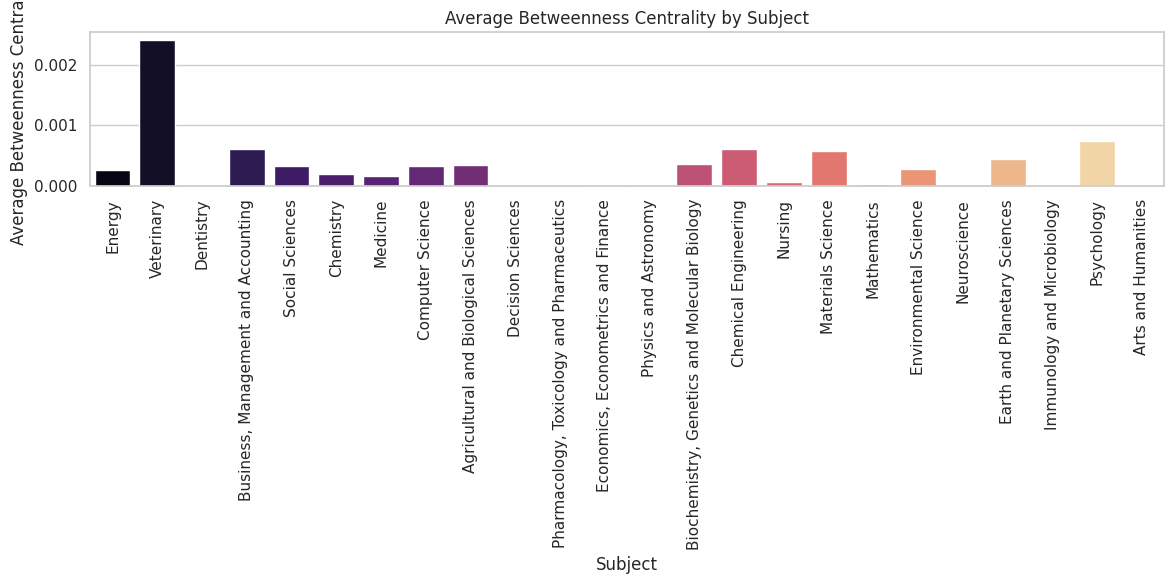

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(x='subject', y='betweenness_centrality', data=centrality_df, ci=None, estimator='mean', palette='magma')
plt.title('Average Betweenness Centrality by Subject')
plt.xlabel('Subject')
plt.ylabel('Average Betweenness Centrality')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [13]:
def plot_top_central_nodes(G, centrality, subject, measure_name, top_n=5):
    # Sort nodes by centrality
    top_nodes = sorted(centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]
    top_node_ids = [node for node, cent in top_nodes]
    
    # Define node colors
    node_colors = ['red' if node in top_node_ids else 'skyblue' for node in G.nodes()]
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=60, node_color=node_colors, alpha=0.6)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # Draw labels for top nodes
    labels = {node: node for node in top_node_ids}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')
    
    plt.title(f'Top {top_n} Nodes by {measure_name.replace("_", " ").title()} in {subject}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage for Degree Centrality
#  

In [14]:
# Assuming your DataFrame has a 'year' column
# Merge centrality measures with year information
# centrality_df = centrality_df.merge(articles[['professor_id', 'year']], on='professor_id', how='left')
import matplotlib.pyplot as plt
# Example plot: Average Degree Centrality Over Years per Subject
plt.figure(figsize=(14, 7))
sns.lineplot(x='year', y='degree_centrality', hue='subject', data=centrality_df, estimator='mean')
plt.title('Average Degree Centrality Over Years by Subject')
plt.xlabel('Year')
plt.ylabel('Average Degree Centrality')
plt.legend(title='Subject')
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.

<Figure size 1400x700 with 0 Axes>